In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [24]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
%config InlineBackend.figure_format = "retina"

# Carga el dataset
df_orig = pd.read_csv("/content/CSV/avocado.csv")
df_orig

df = df_orig.copy()

In [25]:
# Convierte 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

#Para poder escoger un número de period que tenga sentido en seasonal_decompose primero vamos a entender qué datos tengo

# Crear las columnas 'año', 'mes' y 'día'
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Crear una columna 'dia_semana' que tenga el nombre del día de la semana
df['dia_semana'] = df['Date'].dt.day_name()

# Visualizar el resultado
print(df[['Date', 'year', 'Month','dia_semana']].head())

#Ver qué días tengo registros de entrada en mi tabla
df['dia_semana'].unique()

        Date  year  Month dia_semana
0 2015-12-27  2015     12     Sunday
1 2015-12-20  2015     12     Sunday
2 2015-12-13  2015     12     Sunday
3 2015-12-06  2015     12     Sunday
4 2015-11-29  2015     11     Sunday


array(['Sunday'], dtype=object)

In [26]:
# Step 1: Define the unique regions and manually classify them
region_classification = {
    'Albany': 'City',
    'Atlanta': 'City',
    'BaltimoreWashington': 'Region',
    'Boise': 'City',
    'Boston': 'City',
    'BuffaloRochester': 'Region',
    'California': 'GreaterRegion',
    'Charlotte': 'City',
    'Chicago': 'City',
    'CincinnatiDayton': 'Region',
    'Columbus': 'City',
    'DallasFtWorth': 'Region',
    'Denver': 'City',
    'Detroit': 'City',
    'GrandRapids': 'City',
    'GreatLakes': 'GreaterRegion',
    'HarrisburgScranton': 'Region',
    'HartfordSpringfield': 'Region',
    'Houston': 'City',
    'Indianapolis': 'City',
    'Jacksonville': 'City',
    'LasVegas': 'City',
    'LosAngeles': 'City',
    'Louisville': 'City',
    'MiamiFtLauderdale': 'Region',
    'Midsouth': 'GreaterRegion',
    'Nashville': 'City',
    'NewOrleansMobile': 'Region',
    'NewYork': 'City',
    'Northeast': 'GreaterRegion',
    'NorthernNewEngland': 'Region',
    'Orlando': 'City',
    'Philadelphia': 'City',
    'PhoenixTucson': 'Region',
    'Pittsburgh': 'City',
    'Plains': 'GreaterRegion',
    'Portland': 'City',
    'RaleighGreensboro': 'Region',
    'RichmondNorfolk': 'Region',
    'Roanoke': 'City',
    'Sacramento': 'City',
    'SanDiego': 'City',
    'SanFrancisco': 'City',
    'Seattle': 'City',
    'SouthCarolina': 'State',
    'SouthCentral': 'GreaterRegion',
    'Southeast': 'GreaterRegion',
    'Spokane': 'City',
    'StLouis': 'City',
    'Syracuse': 'City',
    'Tampa': 'City',
    'TotalUS': 'TotalUS',
    'West': 'GreaterRegion',
    'WestTexNewMexico': 'Region'
}
def get_regions(name):
  cat_region = region_classification.get(name)
  return cat_region

In [27]:
# Añade columna con categorización de City/Region/GreaterRegion/TotalUS
df['region_type'] = df['region'].transform(lambda x: get_regions(x))

Error cuadrático medio en prueba (interpolación): 0.3961
Error cuadrático medio en extrapolación: 27.1712


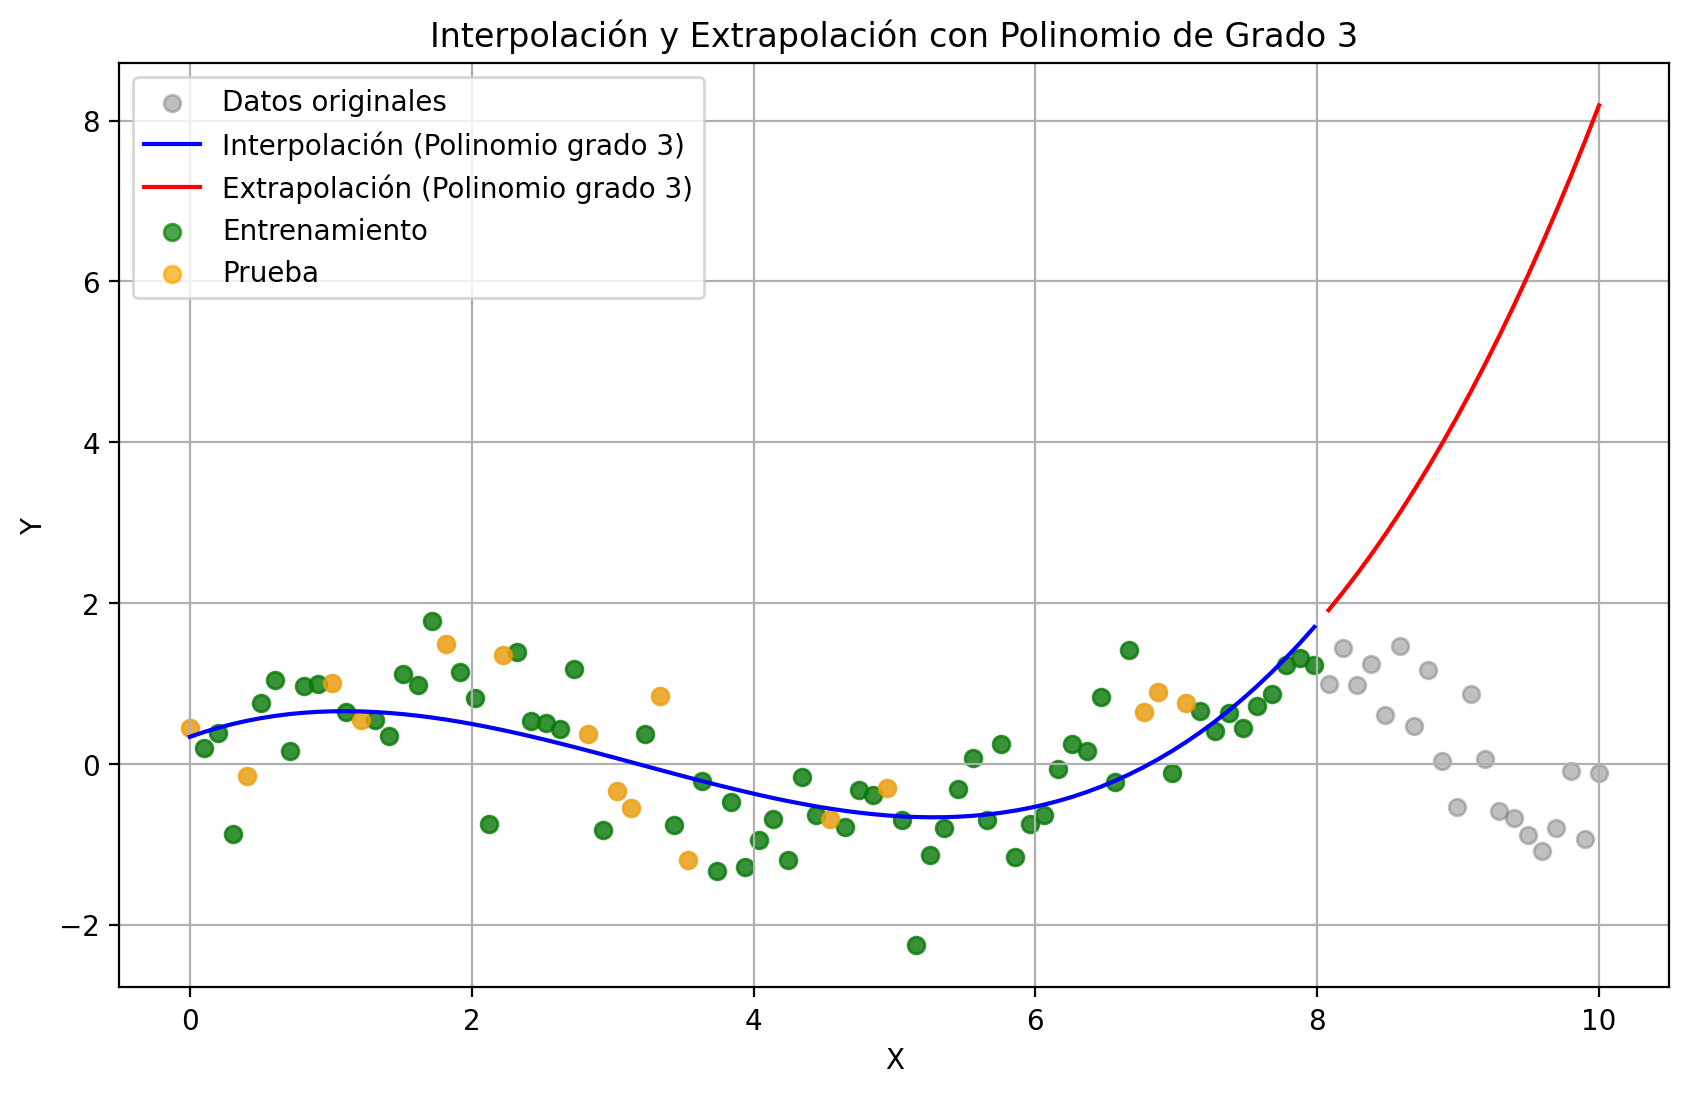

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Filtrar los datos de la ciudad de Boston
df_boston = df[df['region'] == 'Boston']

# Convertir las fechas al índice bimestral
df_boston['bimester'] = (df_boston['Date'].dt.month - 1) // 2 + 1  # Cálculo de bimestre
df_boston['date_numeric'] = df_boston['Date'].map(pd.Timestamp.timestamp)  # Fecha como número (timestamp)


# Asignar los datos a las variables x e y
x = df_boston['Total Volume'].values  # Columna de valores independientes
y = df_boston['date_numeric'].values  # Columna de valores dependientes


# Generar datos de ejemplo
np.random.seed(20)  # Para reproducibilidad
x = np.linspace(0, 10, 100)
y = np.sin(x) + 0.5 * np.random.normal(size=len(x))  # Datos con ruido

# Dividir los datos en interpolación (80%) y extrapolación (20%)
interpolation_size = int(0.8 * len(x))
extrapolation_size = len(x) - interpolation_size

x_interpolation = x[:interpolation_size]
y_interpolation = y[:interpolation_size]

x_extrapolation = x[interpolation_size:]
y_extrapolation = y[interpolation_size:]

# Dividir los datos de interpolación en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(
    x_interpolation, y_interpolation, test_size=0.2, random_state=42
)

# Ajustar un polinomio de grado 3 a los datos de entrenamiento
coefficients = np.polyfit(x_train, y_train, deg=3)
polynomial = np.poly1d(coefficients)

# Predicciones para los datos de prueba e interpolación
y_pred_test = polynomial(x_test)
y_pred_interpolation = polynomial(x_interpolation)

# Predicciones para extrapolación
y_pred_extrapolation = polynomial(x_extrapolation)

# Evaluar el modelo (Error cuadrático medio)
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mse_test = mean_squared_error(y_test, y_pred_test)
mse_extrapolation = mean_squared_error(y_extrapolation, y_pred_extrapolation)

print(f"Error cuadrático medio en prueba (interpolación): {mse_test:.4f}")
print(f"Error cuadrático medio en extrapolación: {mse_extrapolation:.4f}")

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Datos originales
plt.scatter(x, y, color="gray", label="Datos originales", alpha=0.5)

# Ajuste en interpolación
plt.plot(x_interpolation, y_pred_interpolation, color="blue", label="Interpolación (Polinomio grado 3)")

# Predicciones en extrapolación
plt.plot(x_extrapolation, y_pred_extrapolation, color="red", label="Extrapolación (Polinomio grado 3)")

# Datos de entrenamiento y prueba
plt.scatter(x_train, y_train, color="green", label="Entrenamiento", alpha=0.7)
plt.scatter(x_test, y_test, color="orange", label="Prueba", alpha=0.7)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Interpolación y Extrapolación con Polinomio de Grado 3")
plt.legend()
plt.grid()
plt.show()

Error cuadrático medio en prueba (interpolación): 0.4226
Error cuadrático medio en extrapolación: 17.1659


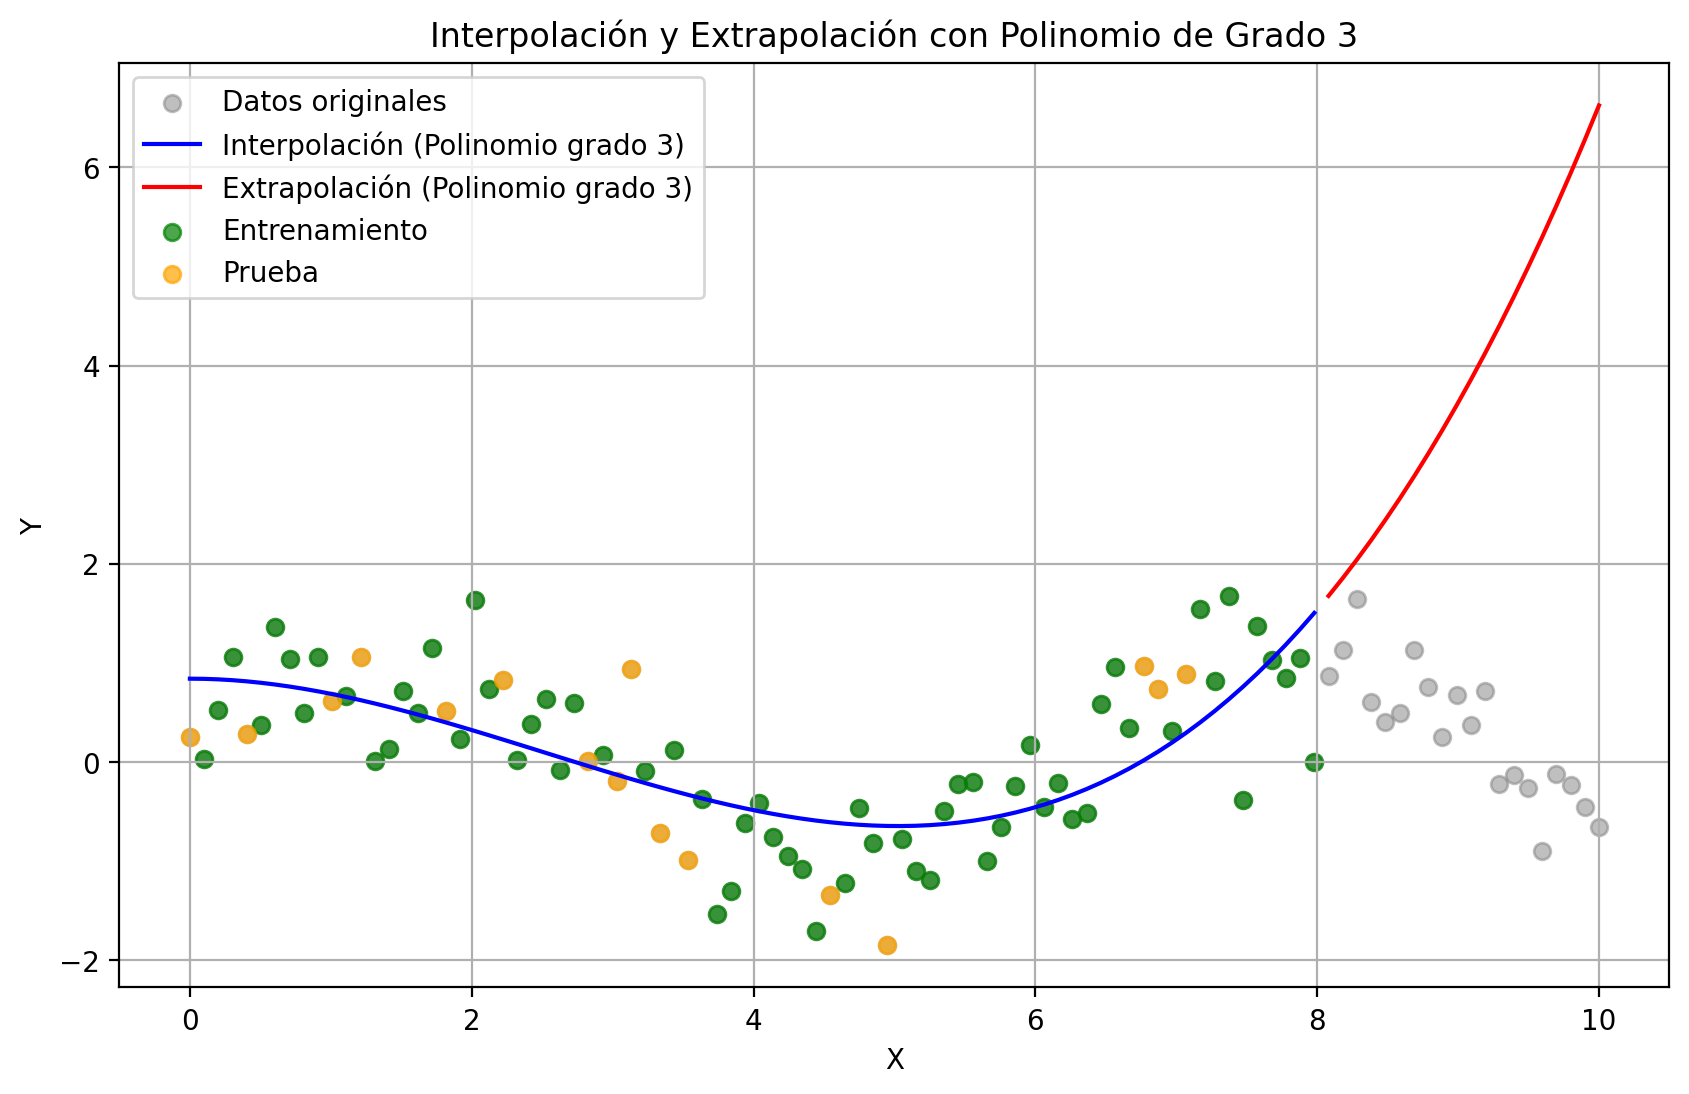

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy.polynomial.polynomial import Polynomial

# Generar datos de ejemplo
np.random.seed(42)  # Para reproducibilidad
x = np.linspace(0, 10, 100)
y = np.sin(x) + 0.5 * np.random.normal(size=len(x))  # Datos con ruido

# Dividir los datos en interpolación (80%) y extrapolación (20%)
interpolation_size = int(0.8 * len(x))
extrapolation_size = len(x) - interpolation_size

x_interpolation = x[:interpolation_size]
y_interpolation = y[:interpolation_size]

x_extrapolation = x[interpolation_size:]
y_extrapolation = y[interpolation_size:]

# Dividir los datos de interpolación en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(
    x_interpolation, y_interpolation, test_size=0.2, random_state=42
)

# Ajustar un polinomio de grado 3 a los datos de entrenamiento
coefficients = np.polyfit(x_train, y_train, deg=3)
polynomial = np.poly1d(coefficients)

# Predicciones para los datos de prueba e interpolación
y_pred_test = polynomial(x_test)
y_pred_interpolation = polynomial(x_interpolation)

# Predicciones para extrapolación
y_pred_extrapolation = polynomial(x_extrapolation)

# Evaluar el modelo (Error cuadrático medio)
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mse_test = mean_squared_error(y_test, y_pred_test)
mse_extrapolation = mean_squared_error(y_extrapolation, y_pred_extrapolation)

print(f"Error cuadrático medio en prueba (interpolación): {mse_test:.4f}")
print(f"Error cuadrático medio en extrapolación: {mse_extrapolation:.4f}")

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Datos originales
plt.scatter(x, y, color="gray", label="Datos originales", alpha=0.5)

# Ajuste en interpolación
plt.plot(x_interpolation, y_pred_interpolation, color="blue", label="Interpolación (Polinomio grado 3)")

# Predicciones en extrapolación
plt.plot(x_extrapolation, y_pred_extrapolation, color="red", label="Extrapolación (Polinomio grado 3)")

# Datos de entrenamiento y prueba
plt.scatter(x_train, y_train, color="green", label="Entrenamiento", alpha=0.7)
plt.scatter(x_test, y_test, color="orange", label="Prueba", alpha=0.7)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Interpolación y Extrapolación con Polinomio de Grado 3")
plt.legend()
plt.grid()
plt.show()